In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

import sys
sys.path.append('../')
from utils.limitcycle import make_limitcycle_dataset
from PhaseReductionNet import Encoder, Decoder, LatentSteper

plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 30 

def to_polar(x):
    theta = torch.atan2(x[:, 1], x[:, 0])
    return theta

In [2]:
device = 'cuda'
enc = Encoder(input_dim=2,output_dim=3,hidden_dim = 100)
step = LatentSteper(zd = 1)
dec = Decoder(input_dim=3,output_dim=2,hidden_dim = 100)

model = 'FHN'
result_dir = f'../out/FHN/'

enc.load_state_dict(torch.load(os.path.join(result_dir,'enc.pth')))
step.load_state_dict(torch.load(os.path.join(result_dir,'step.pth')))
dec.load_state_dict(torch.load(os.path.join(result_dir,'dec.pth')))

enc.to(device)
step.to(device)
dec.to(device)

enc.eval()
step.eval()
dec.eval()
print(step.state_dict())
w = step.state_dict()['theta'].item()
print(w)

X0 = np.load(f'../data/limit_cycle_{model}.npy')
Z0 = np.load(f'../data/phase_response_function_{model}.npy')
print(X0.shape)
mean = np.mean(X0,axis=0)
std = np.std(X0,axis=0)
print(mean,std)

OrderedDict([('theta', tensor(0.3094, device='cuda:0')), ('lam', tensor([0.5455], device='cuda:0'))])
0.30937203764915466
(36563, 2)
[-0.06871168  0.78911364] [1.39785912 0.58533949]


In [3]:
zs = []
ys = []
ps = []
for i in range(0,len(X0),1):
    x = [[(X0[i,0]-mean[0])/std[0],(X0[i,1]-mean[1])/std[1]]]
    x = torch.Tensor(x).to(device,dtype = torch.float)
    z = enc(x)
    p = to_polar(z[:,:2]).item()
    y = dec(z)
    zs.append(z.detach().to('cpu').numpy())
    ys.append(y.detach().to('cpu').numpy())
    ps.append(p)
    
zs = np.concatenate(zs)
ys = np.concatenate(ys)

_ps = []
a = np.linspace(0,2*np.pi,len(ps))
for i in range(len(ps)):
    if w > 0:
        _ps.append((ps[i]-ps[0])%(2*np.pi))
    else:
        _ps.append(2*np.pi-(ps[i]-ps[0]-0.00001)%(2*np.pi)+0.00001)

eX0 = []
#grad = []
e = 0.05
for theta in np.linspace(0,2*np.pi,500):
    z = [[np.cos(theta),np.sin(theta),0.0]]
    z = torch.Tensor(z).to(device,dtype = torch.float)
    out = dec(z)
    nz = [[np.cos(theta+e),np.sin(theta+e),0.0]]
    nz = torch.Tensor(nz).to(device,dtype = torch.float)
    nout = dec(nz)
    eX0.append(out.detach().to('cpu').numpy())
    #grad.append(nout.detach().to('cpu').numpy())
eX0 = np.concatenate(eX0)
#grad = np.concatenate(grad)

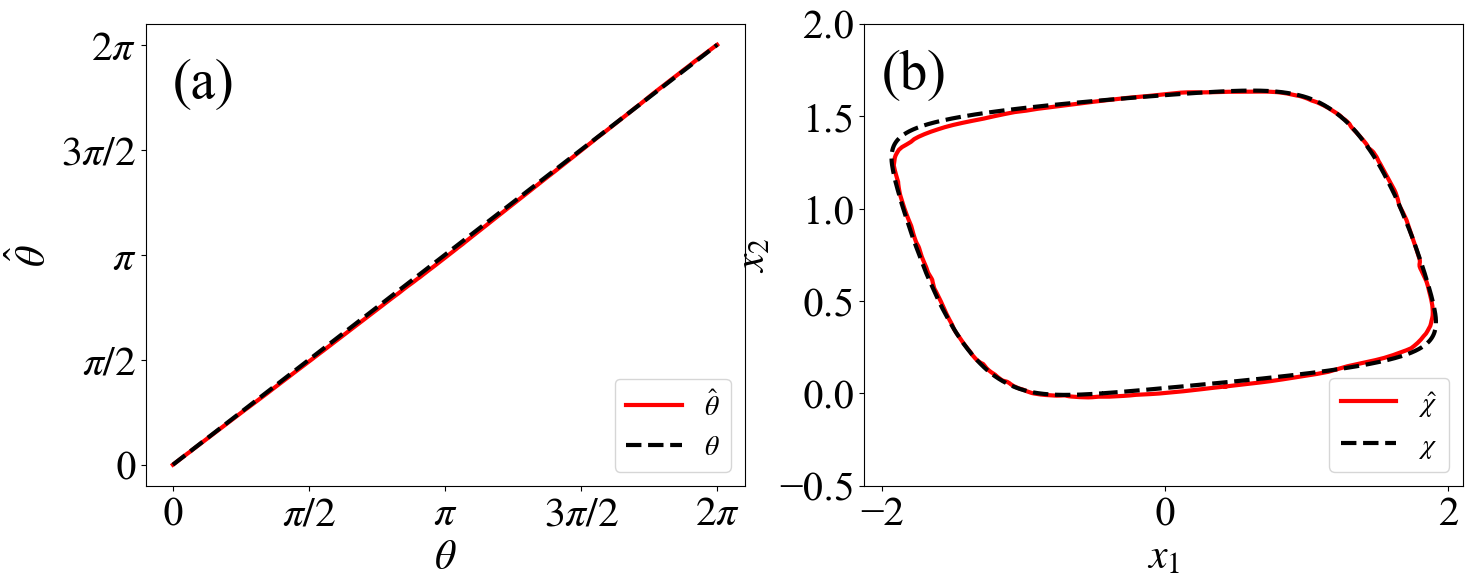

In [4]:
plt.figure(figsize=(17,6))
plt.subplot(1,2,1)
plt.plot(a[:-10],_ps[:-10], color = 'red',label=rf'$\hat \theta$',lw=3)
plt.plot(a,a, color = 'black',linestyle='dashed',label=rf'$\theta$',lw=3)
plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.yticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.text(0,5.5 ,'(a)',fontsize=40)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\hat{\theta}$')
plt.legend(loc='lower right',fontsize=20)
plt.subplot(1,2,2)

plt.plot(eX0[:,0]*std[0]+mean[0],eX0[:,1]*std[1]+mean[1], color = 'red',lw=3,label=r'$\hat \chi$')
plt.plot(X0[:,0],X0[:,1],color='black',label=r'$\chi$',lw=3,linestyle='--')
plt.text(-2,1.65 ,'(b)',fontsize=40)
#plt.xlim(-1.5,1.5)
plt.ylim(-0.5,2)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc = 'lower right',fontsize=20)
plt.savefig('../figure/FHN_LC.pdf', bbox_inches='tight')
plt.show()

In [5]:
grad = []
for i in range(len(X0)):
    x = [[(X0[i,k]-mean[k])/std[k] for k in range(X0.shape[1])]]
    x = torch.Tensor(x).to(device,dtype = torch.float)
    x.requires_grad = True
    p = to_polar(enc(x)[:, :2])
    p.backward()
    z = enc(x)
    grad.append(x.grad.detach().to('cpu').numpy()[0])

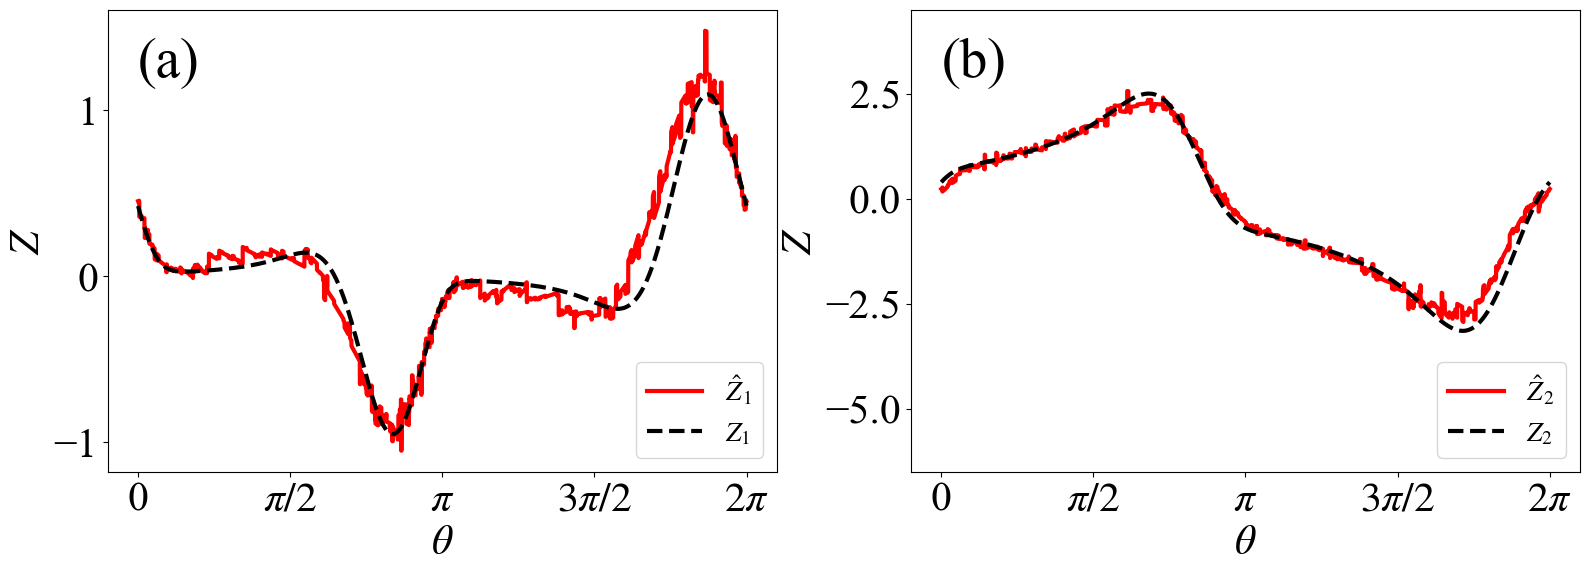

In [6]:
plt.figure(figsize=(19,6))
xx  = np.linspace(0,2*np.pi,len(X0))
for k in range(Z0.shape[1]):
    plt.subplot(1,2,k+1)
    if w>0:
        plt.plot(xx,[grad[i][k]/std[k] for i in range(len(X0))],color='red',label=rf'$\hat Z_{k+1}$',lw=3)
    else:
        plt.plot(xx,[-grad[i][k]/std[k] for i in range(len(X0))],color='red',label=rf'$\hat Z_{k+1}$',lw=3)
    if k==0:
        plt.text(0,1.2,'(a)',fontsize=40)
    if k==1:
        plt.text(0,2.9,'(b)',fontsize=40)
    plt.plot(xx,Z0[:,k],color='black',linestyle='--',label=rf'$Z_{k+1}$',lw=3)
    plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$Z$')
    if k==1:
        plt.ylim(-6.5,4.5)
    plt.legend(loc='lower right',fontsize=20)
plt.savefig(f'../figure/FHN_PSF.pdf', bbox_inches='tight')
plt.show()

-0.19945184886455536


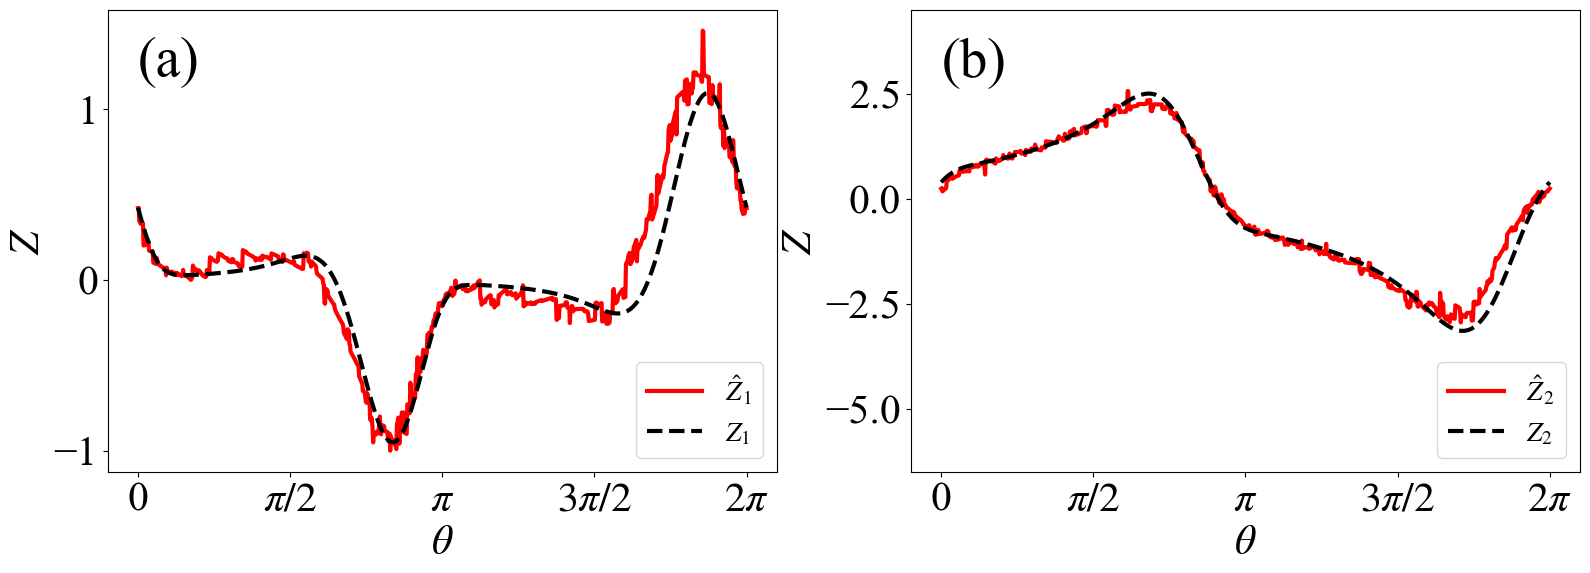

In [7]:
x = [[(X0[0,0]-mean[0])/std[0],(X0[0,1]-mean[1])/std[1]]]
x = torch.Tensor(x).to(device,dtype = torch.float)
x.requires_grad = True
z = enc(x)
p0 = to_polar(enc(x)[:,:2]).item()
print(p0)

grad = []
nnn = 1000
for theta in np.linspace(0,2*np.pi,nnn):
    if w>0:
        _x = [[np.cos(theta+p0),np.sin(theta+p0),0]]
    else:
        _x = [[np.cos(-theta+p0),np.sin(-theta+p0),0]]
    _x = torch.Tensor(_x).to(device,dtype = torch.float)
    _x = dec(_x).detach().to('cpu').numpy()[0]
    _x = [_x[i] for i in range(len(_x))]
    #x = [[(X0[i,k]-mean[k])/std[k] for k in range(X0.shape[1])]]
    x = torch.Tensor([_x]).to(device,dtype = torch.float)
    x.requires_grad = True
    p = to_polar(enc(x)[:, :2])
    p.backward()
    z = enc(x)
    grad.append(x.grad.detach().to('cpu').numpy()[0])

plt.figure(figsize=(19,6))
xx  = np.linspace(0,2*np.pi,nnn)
for k in range(Z0.shape[1]):
    plt.subplot(1,2,k+1)
    if w>0:
        plt.plot(xx,[grad[i][k]/std[k] for i in range(nnn)],color='red',label=rf'$\hat Z_{k+1}$',lw=3)
    else:
        plt.plot(xx,[-grad[i][k]/std[k] for i in range(nnn)],color='red',label=rf'$\hat Z_{k+1}$',lw=3)
    if k==0:
        plt.text(0,1.2,'(a)',fontsize=40)
    if k==1:
        plt.text(0,2.9,'(b)',fontsize=40)
    plt.plot(np.linspace(0,2*np.pi,Z0.shape[0]),Z0[:,k],color='black',linestyle='--',label=rf'$Z_{k+1}$',lw=3)
    plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$Z$')
    if k==1:
        plt.ylim(-6.5,4.5)
    plt.legend(loc='lower right',fontsize=20)
    #plt.savefig(f'Z{model}_x{k+1}.png', bbox_inches='tight')
#plt.savefig(f'Z{model}_x{k+1}.png', bbox_inches='tight')
plt.savefig(f'../figure/FHN_PSF2.pdf', bbox_inches='tight')
plt.show()

In [8]:
#x = torch.Tensor([X0[0,0]]).to(device,dtype = torch.float)
x = [[(X0[0,0]-mean[0])/std[0],(X0[0,1]-mean[1])/std[1]]]
x = torch.Tensor(x).to(device,dtype = torch.float)
print(x)
x.requires_grad = True
z = enc(x)
p0 = to_polar(enc(x)[:,:2]).item()

n = 100
x_vec = []
y_vec = []
t_vec = []
rs = []
for _x in np.linspace(-3,3,n):
    for _y in np.linspace(-0.5,2,n):
        x = [[(_x-mean[0])/std[0],(_y-mean[1])/std[1]]]
        x = torch.Tensor(x).to(device,dtype = torch.float)
        #x = torch.Tensor([[_x,_y]]).to(device,dtype = torch.float)
        x.requires_grad = True
        z = enc(x)
        p = to_polar(enc(x)[:,:2])
        x_vec.append(_x)
        y_vec.append(_y)
        p = p.item()-p0
        if p<0:
            p += 2*np.pi
        t_vec.append(p)
        rs.append(enc(x)[0,2].item())


tensor([[-0.2695, -1.3481]], device='cuda:0')


In [9]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import scipy.integrate as integrate
 
I = 0.8 #external stimulus
A = 0.7
b = 0.8
e = 0.08
 
# 原点
u0 = X0[0,0]
v0 = X0[0,1]
_X0 = [u0, v0]
 
#time
dt = 0.001
idt = 1/dt
t = np.arange(0, 100, dt)
T = 36559 #msec
 
def FHN(state, t):
    """
    FitzHugh-Nagumo added pulse perturbation model
    u : the membrane potential
    v : a recovery variable
    """
    u, v = state
    dudt = -v + u - pow(u,3)/3 + I
    dvdt = e*(u - b * v + A)
    return dudt, dvdt
 
def PhaseField(u,v):
    #軌道を計算
    Xp = integrate.odeint(FHN, [u,v], t)
     
    #軌道中の点と原点の距離を計算
    d = Xp-_X0
    L2 = d[:,0]**2 + d[:,1]**2
     
    #軌道中の点で最も原点に近い最初の点のindex(=time)を取得
    tau_0 = np.argmin(L2)
     
    #周期で割って余りを出す
    tau = tau_0 % T
     
    #位相を2piで割った値
    theta_per_2pi = (1 - tau / T)*2*np.pi
     
    #位相
    #theta = theta_per_2pi * 2*np.pi
    return theta_per_2pi
 
#print(PhaseField(u0,v0)) #1
n = 100

x_vec2 = []
y_vec2 = []
t_vec2 = []

#網羅的に位相を計算
for _x in tqdm(np.linspace(-3,3,n)):
    for _y in np.linspace(-0.5,2,n):
        p = PhaseField(_x,_y)
        x_vec2.append(_x)
        y_vec2.append(_y)
        t_vec2.append(p)
        #print("save : "+str(i*vlen+j))
 


100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


-0.2729 0.5338749999999999


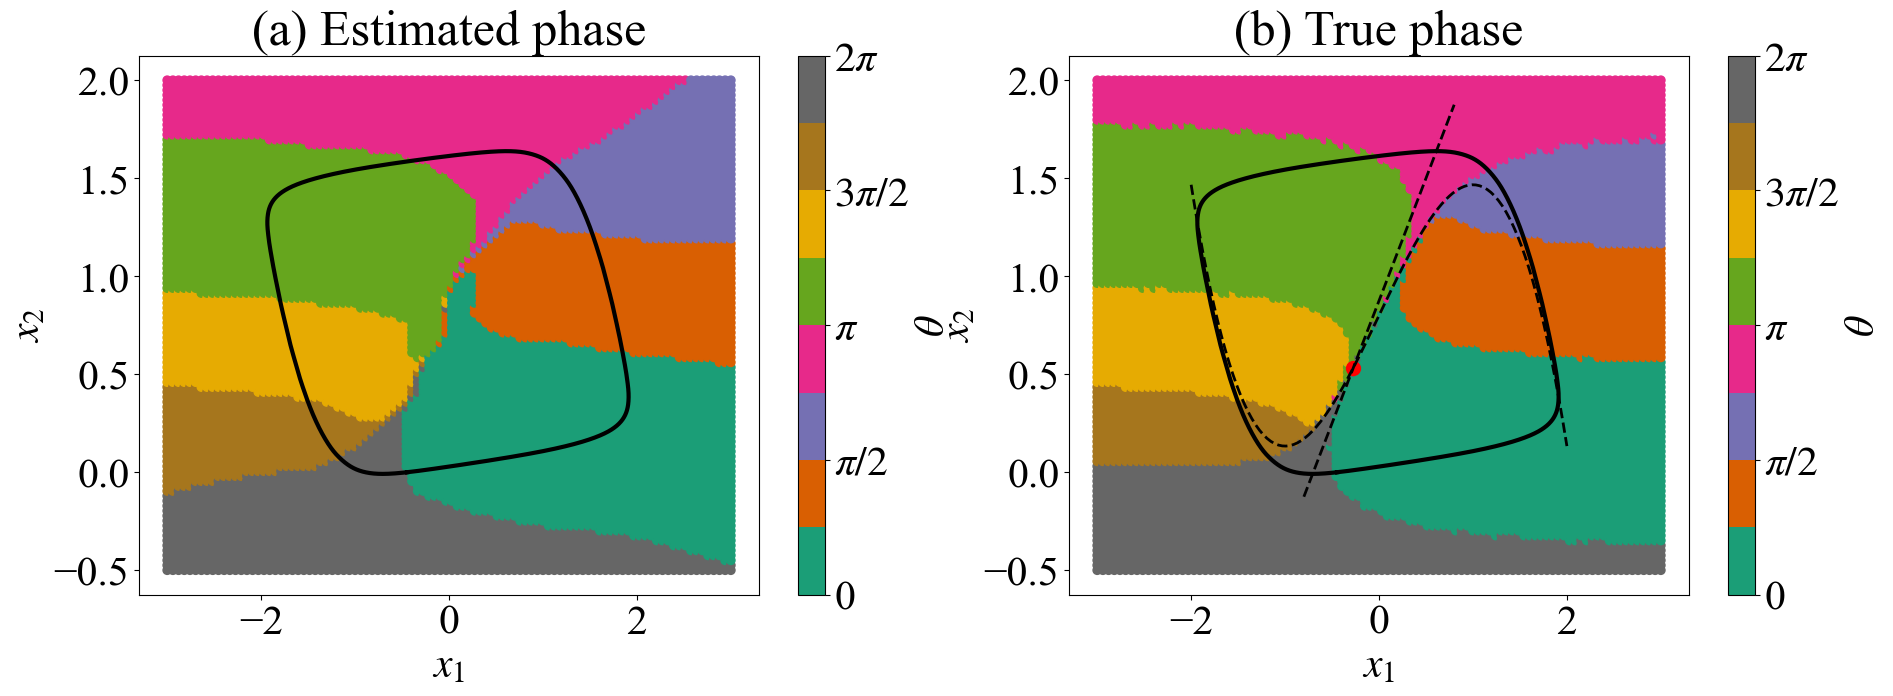

In [10]:
#plt.figure(figsize=(17,6))
fig = plt.figure(figsize=(22,7))
ax = fig.add_subplot(1, 2, 1)
theta = np.linspace(0,2*np.pi,100)
ax.plot(X0[:,0],X0[:,1],color='black',lw=3)
mappable = ax.scatter(x_vec,y_vec,c=t_vec,cmap='Dark2')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('(a) Estimated phase')
pp = fig.colorbar(mappable, ax=ax, label=r'$\theta$')
pp.set_ticks(ticks=[0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               labels=[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
ax = fig.add_subplot(1, 2, 2)
theta = np.linspace(0,2*np.pi,100)
ax.plot(X0[:,0],X0[:,1],color='black',lw=3)
xx1 = np.linspace(-2,2,100)
ax.plot(xx1,xx1-xx1**3/3+0.8,color='black',lw=2,linestyle='dashed')
xx1 = np.linspace(-0.8,0.8,100)
ax.plot(xx1,xx1/0.8+0.7/0.8,color='black',lw=2,linestyle='dashed')
cc = -0.27290
print(cc,cc/0.8+0.7/0.8)
mappable = ax.scatter(x_vec,y_vec,c=t_vec2,cmap='Dark2')
ax.scatter([cc],[cc/0.8+0.7/0.8],s=100,color='red')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('(b) True phase')
pp = fig.colorbar(mappable, ax=ax, label=r'$\theta$')
pp.set_ticks(ticks=[0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               labels=[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.savefig(f'../figure/FHN_PF.pdf', bbox_inches='tight')
plt.show()